# Second Part: Kaggle Competition

In [1]:
from datetime import datetime 
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# import sklearn
# import torch 

## Prepare Data

In [76]:
EMOTION_NAMES = ['joy', 'anticipation', 'trust' , 'sadness' , 'disgust' , 'fear' , 'surprise', 'anger']

In [2]:
ident = pd.read_csv('data/data_identification.csv', index_col='tweet_id')
labels = pd.read_csv('data/emotion.csv', index_col='tweet_id')

print('train size', ident[ident['identification'] == 'train'].shape)
print('test  size', ident[ident['identification'] == 'test'].shape)

print(ident.head(3))
print(labels.head(3))

train size (1455563, 1)
test  size (411972, 1)
         identification
tweet_id               
0x28cc61           test
0x29e452          train
0x2b3819          train
               emotion
tweet_id              
0x3140b1       sadness
0x368b73       disgust
0x296183  anticipation


In [3]:
train_idxs = ident[ident['identification'] == 'train'].index
train_labels = labels.loc[train_idxs, 'emotion']

train_labels.head(3)

tweet_id
0x29e452      joy
0x2b3819      joy
0x2a2acc    trust
Name: emotion, dtype: object

labels distribution
joy             516017
anticipation    248935
trust           205478
sadness         193437
disgust         139101
fear             63999
surprise         48729
anger            39867
Name: emotion, dtype: int64


<AxesSubplot: >

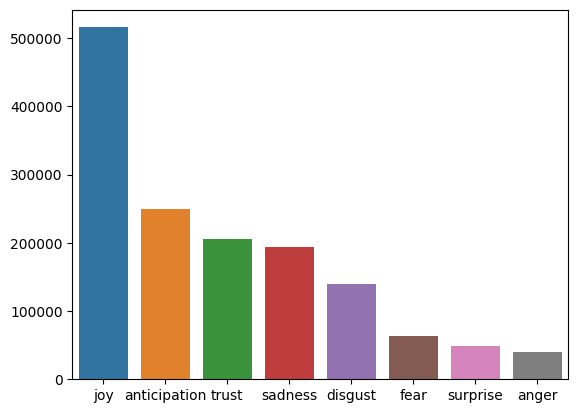

In [4]:
print('labels distribution')
print(train_labels.value_counts())
sns.barplot(x=train_labels.value_counts().index, y=train_labels.value_counts().values)

In [5]:
data = pd.read_json('data/tweets_DM.json', lines=True)

# drop useless columns (only 1 unique value)
data = data.drop(columns=['_index', '_type'])
source = data['_source']

# parsing tweet
def parse_source(data):
    data = data['tweet']
    parsed_data = {}
    for key, value in data.items():
      parsed_data[key] = value
    return parsed_data
tweet = pd.DataFrame(source.map(parse_source).tolist())
data = pd.concat([data, tweet], axis=1)
data = data.drop(columns=['_source'])

data.set_index('tweet_id', inplace=True)

data.head(3)

,_score,_crawldate,hashtags,text
tweet_id,,,,
0x376b20,391,2015-05-23 11:42:47,[Snapchat],"People who post ""add me on #Snapchat"" must be ..."
0x2d5350,433,2016-01-28 04:52:09,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #..."
0x28b412,232,2017-12-25 04:39:20,[bibleverse],"Confident of your obedience, I write to you, k..."


In [6]:
train_data = data.loc[train_idxs, :].sort_values(by='tweet_id')
test_data = data.loc[~data.index.isin(train_idxs), :].sort_values(by='tweet_id')
train_labels = train_labels.sort_index()

assert len(train_data) == len(train_labels)
assert np.all(train_data.index == train_labels.index)
print(len(data))
print(len(train_data), len(test_data))

1867535
1455563 411972


In [ ]:
train_data.to_pickle('data/train_data.pkl')
train_labels.to_pickle('data/train_labels.pkl')
test_data.to_pickle('data/test_data.pkl')

In [ ]:
# FIXME: lost some rows in training data when reading from tsv
# train_data.to_csv('data/train_data.tsv', sep='\t', encoding='utf-8')
# train_labels.to_csv('data/train_labels.tsv', sep='\t', encoding='utf-8')
# test_data.to_csv('data/test_data.tsv', sep='\t', encoding='utf-8')

## Exploratory Data Analysis

In [59]:
n_sample = None
if n_sample != None:
  idxs = np.random.choice(train_idxs, n_sample, replace=False)
  df = pd.concat([data.loc[idxs], train_labels.loc[idxs]], axis=1)
else:
  df = pd.concat([data.loc[train_idxs], train_labels.loc[train_idxs]], axis=1)

print(df.shape)
df.head(3)

(1455563, 5)


,_score,_crawldate,hashtags,text,emotion
tweet_id,,,,,
0x29e452,809,2015-01-17 03:07:03,[],Huge Respect🖒 @JohnnyVegasReal talking about l...,joy
0x2b3819,808,2016-07-02 09:34:06,"[spateradio, app]",Yoooo we hit all our monthly goals with the ne...,joy
0x2a2acc,16,2016-08-15 18:18:39,[],@KIDSNTS @PICU_BCH @uhbcomms @BWCHBoss Well do...,trust


### Hashtag

In [69]:
threshold = 30
tags_count = df['hashtags'].map(lambda x: [tag.lower() for tag in x]).explode().value_counts()
tags_count = tags_count[tags_count > threshold]

no_tag_cnt = df["hashtags"].map(lambda x: len(x)).value_counts()[0]
print(f'# of tags above threshold {threshold}: {len(tags_count)}')
print(f'# of no tags: {no_tag_cnt} ({no_tag_cnt / len(df) * 100 :.2f}%)')
print()
print(tags_count)
px.histogram(tags_count, x=tags_count.index, y=tags_count.values)

# of tags above threshold 30: 6523
# of no tags: 696358 (47.84%)

life               26147
love               14038
god                12177
dream               6964
blessed             6937
                   ...  
knackered             31
nerves                31
endusaid2israel       31
amex                  31
yoursong              31
Name: hashtags, Length: 6523, dtype: int64


In [72]:
tagsInEmotion = df.groupby('emotion').agg({'hashtags': lambda x: x \
                            .map(lambda x: [tag.lower() for tag in x])
                            .explode()
                            .value_counts().index.tolist()
                          }).T

for emotion in tagsInEmotion.columns:
  print(emotion)
  print(tagsInEmotion[emotion][0][:20])

anger
['bb19', 'anger', 'pissed', 'mad', 'angry', 'frustrated', 'annoyed', 'rage', 'tired', 'wrath', 'bb19finale', 'ill', 'fedup', 'enraged', 'trump', 'football', 'help', 'offended', 'collegefootball', 'big10']
anticipation
['life', 'god', 'dream', 'jesus', 'faith', 'motivation', 'excited', 'pray', 'believe', 'success', 'wisdom', 'trump', 'maga', 'mondaymotivation', 'inspiration', 'christ', 'entrepreneur', 'inspire', 'people', 'world']
disgust
['wtf', 'shame', 'stupid', 'trump', 'dumb', 'bb19', 'smh', 'nfl', 'lol', 'maga', 'why', 'lame', 'fail', 'resist', 'charlottesville', 'racist', 'gameofthrones', 'fml', 'gross', 'disgusting']
fear
['insecure', 'fear', 'jealous', 'halloween', 'power', 'gameofthrones', 'anxiety', 'got', 'treats', 'life', 'scared', 'nervous', 'courage', 'spooky', 'success', 'scary', 'trump', 'fridaythe13th', 'issa', 'help']
joy
['love', 'life', 'blessed', 'special', 'everyday', 'female', 'awesome', 'faith', 'hope', 'happy', 'content', 'amazing', 'thanks', 'motivation'

#### Tag Frequency

In [80]:
tags_count = df['hashtags'].map(lambda x: [tag.lower() for tag in x]).explode().value_counts()
unique_tags = list(tags_count.index.tolist())
tags_count

life                         26147
love                         14038
god                          12177
dream                         6964
blessed                       6937
                             ...  
felloff                          1
godlovesyoumorethananyone        1
sensimar                         1
dosomethingyoulove               1
ldsquote                         1
Name: hashtags, Length: 325136, dtype: int64

#### Tags emotions distribution

In [82]:
tagEmoCnt = pd.DataFrame(np.zeros((len(unique_tags), len(EMOTION_NAMES))), index=unique_tags, columns=EMOTION_NAMES, dtype=int)

for emotion in EMOTION_NAMES:
  for tag in unique_tags:
    tagEmoCnt.loc[tag, emotion] = df[df['emotion'] == emotion]['hashtags'].map(lambda x: tag in x).sum()

tagEmoCnt

KeyboardInterrupt: 

In [ ]:
tagEmoCnt.to_csv('eda/tagEmoCnt.csv')

### What `_score` means?

### Hashtag

## Transfer Learning from Hugging Face 

In [2]:
from datasets import Dataset, load_dataset
import evaluate

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import pipeline

from transformers import XLNetTokenizer, XLNetForSequenceClassification

/home/alan/dm/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-11-14 21:45:26.883672: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-14 21:45:27.013030: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-14 21:45:27.514312: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object fi

In [18]:
# data
TRAIN_DATA_PATH = 'data/train_data.pkl'
TRAIN_LABEL_PATH = 'data/train_labels.pkl'
TEST_DATA_PATH = 'data/test_data.pkl'
EMOTION_NAMES = ['joy', 'anticipation', 'trust' , 'sadness' , 'disgust' , 'fear' , 'surprise', 'anger']

# constants
MODEL_NAME = 'bert-base-cased'
# MODEL_NAME = 'roberta-base'
# MODEL_NAME = 'cardiffnlp/twitter-roberta-base-sentiment'
NUM_LABELS = 8

# hyper-parameters
EPOCHS = 5
BATCH_SIZE = 8

In [19]:
emotion2id = {emotion: i for i, emotion in enumerate(EMOTION_NAMES)}
id2emotion = {i: emotion for i, emotion in enumerate(EMOTION_NAMES)}

In [20]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

loading configuration file config.json from cache at /home/alan/.cache/huggingface/hub/models--bert-base-cased/snapshots/a8d257ba9925ef39f3036bfc338acf5283c512d9/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file vocab.txt from cache at /home/alan/.cache/huggingface/hub/models--bert-base-cased/snapshots/a8d257ba9925ef39f3036bfc338acf5283c512d9/vocab.txt
loading fil

In [21]:
df_train_X = pd.read_pickle(TRAIN_DATA_PATH)
df_train_y = pd.read_pickle(TRAIN_LABEL_PATH)
assert len(df_train_X) == len(df_train_y)
df_train = pd.concat([df_train_X, df_train_y], axis=1)

# numerical labels
df_train['label'] = df_train['emotion'].map(lambda x: emotion2id[x])

df_train.sample(5)

,_score,_crawldate,hashtags,text,emotion,label
tweet_id,,,,,,
0x2f8049,768,2015-08-22 21:15:45,[cantevenmanagefood],Do I have to be an adult today 😭😷 <LH> #cantev...,disgust,4
0x32eec5,686,2016-05-18 23:19:28,[],@DavidHaydnJones I got a call from casting age...,joy,0
0x25a9b8,705,2016-02-12 05:03:29,[],@Skyler23 @DavidSchechter if my screen was tha...,disgust,4
0x2f1906,1017,2015-06-17 19:38:26,[],How good are birthdays? It’s a day of people t...,anticipation,1
0x2fbd2d,727,2016-05-06 19:24:09,[],Excuse me can I talk to you for a moment?waits...,disgust,4


In [22]:
dataset = Dataset.from_pandas(df_train[['text', 'label']])

In [23]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.save_to_disk(f'data/{MODEL_NAME}_tokenized_datasets')

100%|█████████▉| 1455/1456 [03:59<00:00,  6.08ba/s]


In [24]:
tokenized_datasets = Dataset.load_from_disk(f'data/{MODEL_NAME}_tokenized_datasets')

In [25]:
small_train_dataset = tokenized_datasets.shuffle(seed=42).select(range(10000))
small_eval_dataset = tokenized_datasets.shuffle(seed=42).select(range(10000, 2*10000))

Loading cached shuffled indices for dataset at data/bert-base-cased_tokenized_datasets/cache-34d9ef7984eaf4aa.arrow


In [26]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

loading configuration file config.json from cache at /home/alan/.cache/huggingface/hub/models--bert-base-cased/snapshots/a8d257ba9925ef39f3036bfc338acf5283c512d9/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_laye

In [27]:
training_args = TrainingArguments(
    output_dir="test_trainer", 
    evaluation_strategy="epoch",
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [28]:
f1_metric = evaluate.load("f1")
acu_metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    f1_macro = f1_metric.compute(predictions=predictions, references=labels, average='macro')['f1']
    acu = acu_metric.compute(predictions=predictions, references=labels)['accuracy']
    return {'f1_macro': f1_macro, 'acu': acu}


In [29]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics
)

In [30]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, tweet_id. If text, tweet_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/home/alan/dm/venv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 10000
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 6250
  Number of trainable parameters = 108316424


Epoch,Training Loss,Validation Loss,F1 Macro,Acu
1,1.535000,1.449239,0.244526,0.477100


Saving model checkpoint to test_trainer/checkpoint-500
Configuration saved in test_trainer/checkpoint-500/config.json
Model weights saved in test_trainer/checkpoint-500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-1000
Configuration saved in test_trainer/checkpoint-1000/config.json
Model weights saved in test_trainer/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text, tweet_id. If text, tweet_id are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 10000
  Batch size = 8
Saving model checkpoint to test_trainer/checkpoint-1500
Configuration saved in test_trainer/checkpoint-1500/config.json
Model weights saved in test_trainer/checkpoint-1500/pytorch_model.bin
Saving model checkpoint to test_trainer/checkpoint-2000
Configuration saved in test_

In [ ]:
model.save_pretrained(f'model/{MODEL_NAME}-10000')

Configuration saved in model/bert-base-cased-10000/config.json
Model weights saved in model/bert-base-cased-10000/pytorch_model.bin


## Evaluation

In [ ]:
classifier = pipeline(
    'sentiment-analysis', 
    model=model, 
    tokenizer=tokenizer,
    device=0,
)

In [ ]:
tdf = pd.DataFrame(classifier(small_eval_dataset['text']))
tdf['answer'] = pd.DataFrame(small_eval_dataset['label'])
tdf['pred'] = tdf['label']
tdf.drop(columns=['label'], inplace=True)

tdf

Disabling tokenizer parallelism, we're using DataLoader multithreading already


,score,answer,pred
0,0.670594,2,LABEL_0
1,0.435329,1,LABEL_1
2,0.709205,3,LABEL_0
3,0.487359,0,LABEL_0
4,0.459186,3,LABEL_4
...,...,...,...
4995,0.466181,4,LABEL_3
4996,0.780630,3,LABEL_0
4997,0.279947,1,LABEL_3
4998,0.779208,0,LABEL_2


In [ ]:
tdf['results'] = tdf['pred'].map(lambda s: int(s[-1])) == tdf['answer']
tdf['results'] = tdf['results'].astype(float)

In [ ]:
tdf['results'].describe()

count    5000.000000
mean        0.478400
std         0.499583
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: results, dtype: float64

## Inference

In [ ]:
TEST_BATCH_SIZE = 64

In [ ]:
df_test = pd.read_pickle(TEST_DATA_PATH)
df_test.sample(5)

,_score,_crawldate,hashtags,text
tweet_id,,,,
0x286a33,975,2016-01-03 21:35:53,[bethebest],"Well what a week! A new car, a promotion in wo..."
0x22723e,840,2016-03-07 05:53:35,[],@emilykoelling Loved seeing your sweet family ...
0x2011a8,282,2017-04-01 01:32:02,[stupidity],@timesofindia Bha...tumse na ho payega....ever...
0x1db71f,702,2016-02-23 08:19:30,[DumbassFolks],Is it so hard to stand on a freaking payload??...
0x226d6b,593,2017-09-17 06:09:08,[],My aunt called me and told me she was ordering...


In [ ]:
classifier = pipeline(
    'sentiment-analysis', 
    model=model, 
    tokenizer=tokenizer,
    device=0,
)

In [ ]:
end_idx = None

# prediction
df_result = pd.DataFrame(classifier(df_test['text'][:end_idx].tolist(), batch_size=TEST_BATCH_SIZE))
# tweet_id as id
df_result['id'] = df_test.index[:end_idx]
# convert label to emotion
df_result['emotion'] = df_result['label'].map(lambda s: id2emotion[int(s[-1])])

df_result.head(3)

,label,score,tweet_id
0,LABEL_3,0.748996,0x1c7f0f
1,LABEL_0,0.586174,0x1c7f12
2,LABEL_2,0.512732,0x1c7f13


In [ ]:
df_result[['tweet_id', 'emotion']].to_csv(f'answer/01.csv', index=False)